<a href="https://colab.research.google.com/github/kennethjiang/3DPrintSaviour/blob/master/Anomaly_Detection_Nezih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

from glob import glob
glob("/content/drive/MyDrive/timelapses/*", recursive = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/timelapses/DASH_480.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-3.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-4.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-5.mp4',
 '/content/drive/MyDrive/timelapses/DASH_480-2.mp4',
 '/content/drive/MyDrive/timelapses/DASH_720-7.mp4',
 '/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4',
 '/content/drive/MyDrive/timelapses/Merged_0.15mm_PLA_MK3SMMU2S_1h8m_20220324025925.mp4',
 '/content/drive/MyDrive/timelapses/Lever_0.15mm_PLA_MK3SMMU2S_5h26m_20220501013518.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240.mp4',
 '/content/drive/MyDrive/timelapses/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220503163150.mp4',
 '/content/drive/MyDrive/timelapses/newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220509072520.mp4',
 '/content/drive/MyDrive/timelapses/Pix

In [102]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

In [103]:
%pip install sewar==0.4.5

import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# from sewar.full_ref import mse, rmse, psnr, uqi, ergas, scc, rase, sam, msssim, vifp
from sewar.full_ref import mse, rmse
from skimage.metrics import structural_similarity as ssim
import os
from sklearn.cluster import DBSCAN
import scipy
import scipy.signal
from numpy import linalg as LA
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import logging
import math
from shapely.geometry import Polygon, Point

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
def read_next_frame(cap):
  """
  Read the next frame from the video, and resize MAX_WIDTH if necessary.
  """
  resize = 0
  width = int(cap.get(3))
  height = int(cap.get(4))
  if width>MAX_WIDTH:
    dividor = MAX_WIDTH/width
    height = int(dividor*height)
    width = MAX_WIDTH
    resize = 1

  _, frame = cap.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if resize:
    return cv2.resize(frame, (width,height), interpolation= cv2.INTER_LINEAR)
  else:
    return frame


In [146]:
def extractSIFT(frame):
    """
    Extracts SIFT features from the frame
    """
    # Gaussian blur kernel size:
    blur_kernel = 5

    # Get frame dimensions:
    width = frame.shape[1]
    height = frame.shape[0]

    # extract RootSIFT descriptors
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    # Gaussian blur:
    frame = cv2.GaussianBlur(frame,(blur_kernel,blur_kernel),0)

    # Copy of the frame:
    # frameOrg = frame.copy()

    # Another copy of the frame (for drawing clusters):
    # imageToDrawClusters = frame.copy()

    # Extract SIFT features:
    return sift.detectAndCompute(frame.astype(np.uint8),None)

In [147]:
def getFeaturesMask(frame, kps, savePNG = False):
    """
    Returns a mask created by these features.
    But how? What kind of role does DBSCAN plays? Nezih Topaloglu please elaborate!
    """

    # DBSCAN parameters:
    eps = 15
    min_samples = 3

    number_of_dilation_iterations = 12

    # Definition of arrays:
    siftArray = []
    maskXarray = []
    maskYarray = []

    # The x and y coordinates of keypoints are stored in separate arrays:
    for i in range(len(kps)):
        maskX = int(kps[i].pt[0])
        maskY = int(kps[i].pt[1])
        maskXarray.append(maskX)
        maskYarray.append(maskY)



    # Combine the arrays and convert them to numpy arrays:
    duo = tuple((maskYarray, maskXarray))
    mydata = np.array(duo).T

    # Clustering:
    try:
        # DBSCAN model with parameters
        model = DBSCAN(eps=eps, min_samples=min_samples).fit(mydata)
    except ValueError:
        print("not enough data for clustering.")
        return False,None,None


    labels = model.labels_

    # Unique labels:
    unique_labels = set(labels)



    # Draw clusters (for debugging):
    # unique_labels_list = list(unique_labels)
    # max_label = max(unique_labels) + 1
    # for i in range(labels.shape[0]):
    #     if labels[i] == -1:
    #         radius = 8
    #     else:
    #         radius = 4
    #         #print('non noise label :',labels[i])
    #         #colorTrio = tuple(colors[labels[i]]*255)
    #     colorSingle = 255 * (labels[i] + 1) / max_label
    #     colorTrio = (colorSingle, colorSingle, colorSingle)
    #         #print('colurTrio ',colorTrio)
    #     cv2.circle(imageToDrawClusters, (mydata[i, 1], mydata[i, 0]),
    #             radius=radius,
    #             color=colorTrio,
    #             thickness=-1)
    # plt.imshow(imageToDrawClusters)
    # plt.show()


    # Outliers are removed from the data:
    myDataWithoutOutliers = mydata[np.where(labels != -1)]


    # Draw clusters without outliers (for debugging):
    # frameOrgWithCleanedData = frameOrg.copy()
    # for i in range(len(myDataWithoutOutliers)):
    #     maskY = myDataWithoutOutliers[i][0]
    #     maskX = myDataWithoutOutliers[i][1]
    #     cv2.circle(frameOrgWithCleanedData, (maskX, maskY),
    #     radius=5,
    #     color=(255,255,255),
    #     thickness=-1)
    # plt.imshow(frameOrgWithCleanedData)
    # plt.show()

    # Create a mask from the data:
    mask1 = np.zeros_like(frame)
    mask1[tuple((myDataWithoutOutliers[:,0],myDataWithoutOutliers[:,1]))] = 255

    # The kernel for dilation:
    kernel = np.ones((5,5), np.uint8)

    # Dilate the image to combine the non-contiguous 1s:
    output_mask = cv2.dilate(mask1, kernel, iterations=number_of_dilation_iterations)


    return True,output_mask

In [155]:
def calc2FrameDiffAbs(frameDuo):

    frame1 = frameDuo[0].astype(np.float32)
    frame1 /= 255
    # print(frame1.shape)

    frame2 = frameDuo[1].astype(np.float32)
    frame2 /= 255

    frame2 -= frame1
    # print(frame2.shape)

    final = np.zeros_like(frame2)
    # cv2.normalize(np.abs(frame2), final, 0, 255, cv2.NORM_MINMAX)
    # print(final.shape)
    # print(np.mean(final))
    # return final.astype(np.uint8)

    return (np.abs(frame2)*255).astype(np.uint8)

In [156]:
def get_cropped_init_layer_duo(firstFrame, cap):
    
    # If initial_layer_frame is not 0, the video is read until the initial_layer_frame:
    if initial_layer_frame:

        #   SIFT mask is created using the first frame:
        
        ## My best guess of this part is to use SIFT to extract feature, and create a mask in the feature-rich areas.
        ## However, this is based on 2 assumptions that beg verification:
        ##   1. The print bed is clean. Many users' print beds are really messy
        ##   2. The "background area" is feature rich. This may not be the case

        ## Also why is this based on the cropped area, instead of the whole picture? Aren't the fringe areas a lot more
        ## likely to be the background, instead of the object? Nezih Topaloglu

        frame = firstFrame[yMin:yMax,xMin:xMax]
        kps, descs = extractSIFT(frame)

        img3=cv2.drawKeypoints(frame,kps,frame)
        plt.imshow(img3,),plt.show()
        print('^^^^Cropped image with SIFT overlay^^^^\n\n')

        ret_sift,sift_mask = getFeaturesMask(frame, kps)
        plt.imshow(frame * (sift_mask/255), cmap='gray'),plt.show()
        print('^^^Cropped image masked by the feature clusers^^^^\n\n')


        frameNo = 2
        if initial_layer_frame == 1:
            frame0 = firstFrame.copy()
            frame1 = read_next_frame(cap)
            frameNo+=1

        else:
            while frameNo <= initial_layer_frame:
                ## After this while loop ends, frame0 is the frame at "initial_layer_frame-1"
                frame0 = read_next_frame(cap)
                frameNo+=1
            ## frame1 is the frame at "initial_layer_frame"
            frame1 = read_next_frame(cap)
            frameNo+=1

        # frame0Cropped is the frame before the initial layer frame:
        frame0Cropped = frame0[yMin:yMax,xMin:xMax]
        # frame1Cropped is the initial layer frame:
        frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        # frame1 = frame1[:,xRange]

        # initial_layer_diff_frame is the difference between the two frames:
        initial_layer_diff_frame = calc2FrameDiffAbs(np.stack((frame0Cropped,frame1Cropped)))

        plt.imshow(initial_layer_diff_frame, cmap='gray'),plt.show()
        print('^^^Cropped image diff between layer 0 (empty bed) and layer 1 (initial layer)^^^^\n\n')


        # If SIFT mask gives an output, the regions with these features are removed from the initial_layer_diff_frame:
        if ret_sift:
            sift_mask = np.bitwise_not(sift_mask)/255

            initial_layer_diff_frame = np.multiply(initial_layer_diff_frame,sift_mask).astype(np.uint8)

        plt.imshow(initial_layer_diff_frame, cmap='gray'),plt.show()
        print('^^^Cropped, masked image diff between layer 0 (empty bed) and layer 1 (initial layer)^^^^\n\n')

        # If useConvexHull is True, the convex hull is calculated:
        if useConvexHull:
            # The weight matrix, which is the result of the convex hull calculation, is found:
            print("Calculating convex hull, at frame: ",frameNo)
            ret_convex_hull,weight_matrix,weight_matrix_binary,_,_,_ = calculateConvexHull(initial_layer_diff_frame,url[7:-4],provideURL = False)
        else:
            ret_convex_hull = False
            # If the convex hull is not used, the weight matrix is a matrix of 1s, which was defined earlier.


        # print(f"hx1,hy1,hx2,hy2 = {hx1,hy1,hx2,hy2}")
        # weight_matrix[hy1:hy2,hx1:hx2] = weight_reduction_factor
        # weight_matrix = weight_matrix + weight_matrix_offset

    else:
        # If there is no initial layer frame, thw weight matrix is unchanged (it's a matrix of 1s)
        frame1 = firstFrame.copy()
        # frame1 = frame1[yRange,:]
        # frame1 = frame1[:,xRange]
        frame1Cropped = frame1[yMin:yMax,xMin:xMax]
        ret_convex_hull = False



## This is the end of helper functions

-------

## Everything below is the main flow 

In [157]:
## Initial variables

MAX_WIDTH = 640
useConvexHull = False

url = '/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4'
initial_layer_frame = 121

In [158]:
## Open the video and get its metadata such as width/height

cap = cv2.VideoCapture(url)

totalFrames = int(cap.get(7))
fps = int(cap.get(5))

firstFrame = read_next_frame(cap)
width = firstFrame.shape[1]
height = firstFrame.shape[0]

print(f'W: {width}, H: {height}')

W: 640, H: 480


In [159]:
## Establish some kind of mask, with the assumptions(!) that:
##  1. the object is rought at the center;
##  2. the "up" direction is -Y

crop_ratio = 0.18

# Using the crop_ratio, the outer part of the video is determined:
yRange = range(int(height*crop_ratio),int(height*(1-crop_ratio)))
xRange = range(int(width*crop_ratio),int(width*(1-crop_ratio)))


yMin = yRange[0]
yMax = yRange[-1]
xMin = xRange[0]
xMax = xRange[-1]
heightCropped = len(yRange)-1
widthCropped = len(xRange)-1

# The weight matrix is created, using the cropped video data:
weight_matrix = np.ones((heightCropped,widthCropped))

print(f'xRange: {xRange}')
print(f'yRange: {yRange}')
print(f'weight_matrix.shape: {weight_matrix.shape}')

xRange: range(115, 524)
yRange: range(86, 393)
weight_matrix.shape: (306, 408)


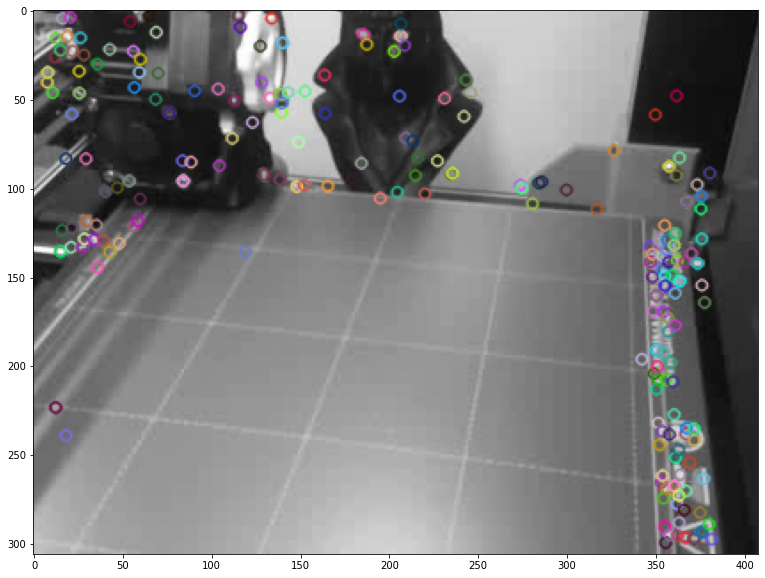

^^^^Cropped image with SIFT overlay^^^^




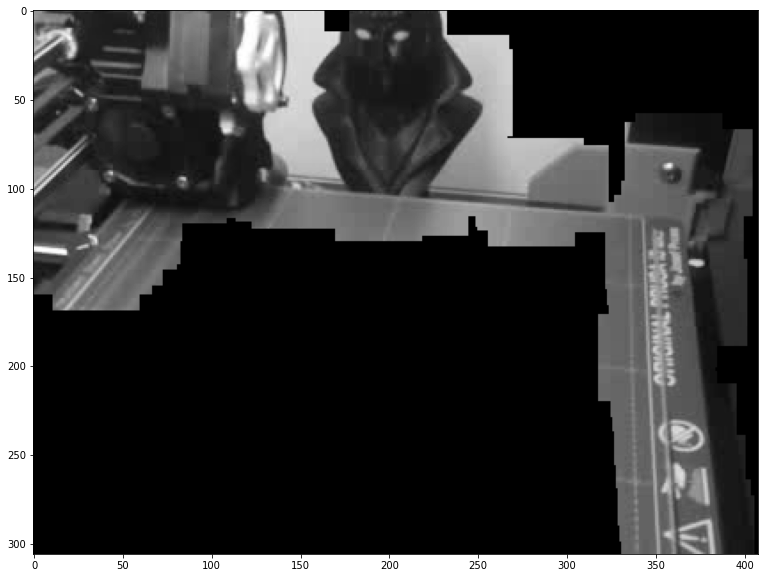

^^^Cropped image masked by the feature clusers^^^^




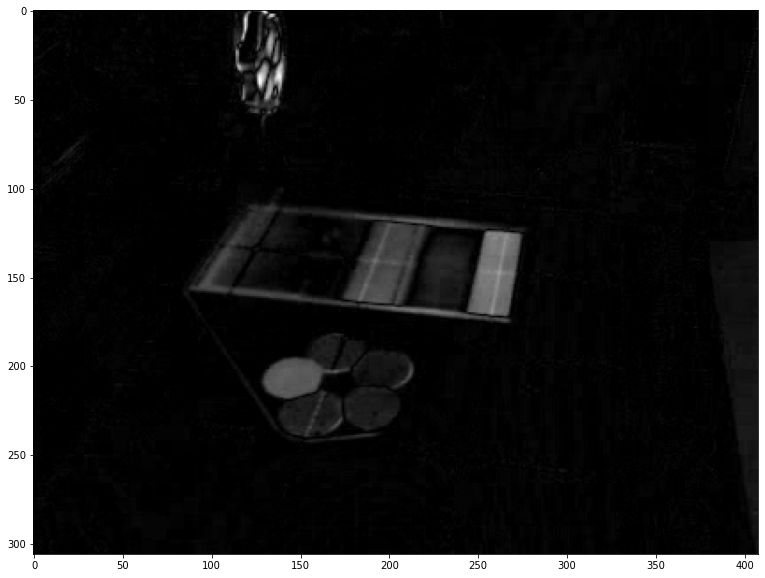

^^^Cropped image diff between layer 0 (empty bed) and layer 1 (initial layer)^^^^




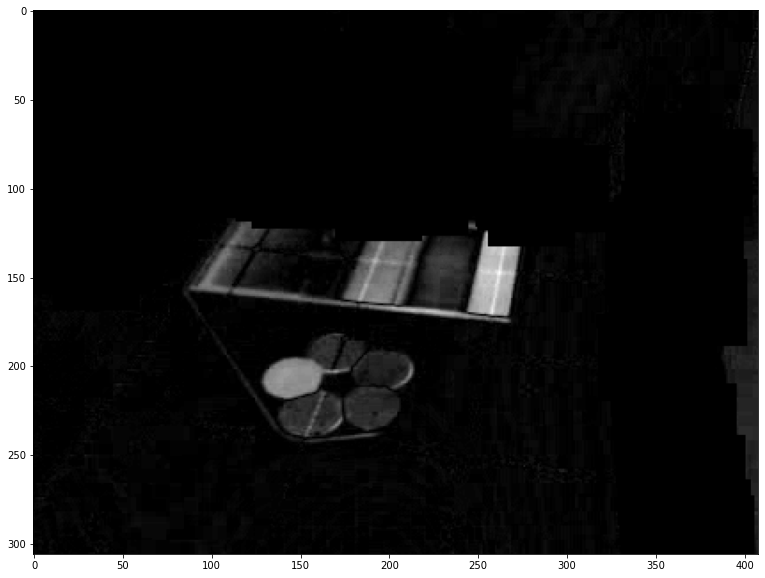

^^^Cropped, masked image diff between layer 0 (empty bed) and layer 1 (initial layer)^^^^




In [160]:
get_cropped_init_layer_duo(firstFrame, cap)